In [3]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

**Problem 1:** Compute formula for the overlap area of two circles as a function
of their separation, b, and radius ratio, $k=R_p/R_*$.

**Problem 2:** Write a function to compute the transit/secondary eclipse of a
body without limb-darkening.

In [52]:
def fractionArea(d, r, R):
    
    if d 
        u = (R**2 + d**2 - r**2)/(2*R*d)
        v = (r**2 + d**2 - R**2)/(2*r*d)

        A = (R**2)*np.arccos(u) + (r**2)*np.arccos(v) - .5*(R**2)*u*np.sqrt(1-u**2) - .5*(r**2)*v*np.sqrt(1-v**2)
    
    return A



In [4]:
def theta(t, t0, P):
    return 2*math.pi/P*(t - t0)

def skySep(t, a, i, t0, P):
#     d = b * np.sqrt((np.cos(theta(t, t0, P))/np.cos(i))**2 + np.sin(theta(t, t0, P))**2)
    d = a * np.sqrt(np.cos(theta(t, t0, P))**2 + np.cos(i)**2 * np.sin(theta(t, t0, P))**2)
    return d

In [28]:
def blockedArea(d, k):
    u = (d**2 + 1 - k**2)/(2*d)
    v = (d**2 + k**2 - 1)/(2*d*k)
    
    A1 = np.arccos(u) - u*np.sqrt(1 - u**2)
    A2 = k**2*np.arccos(v) - k**2*v*np.sqrt(1 - v**2)
    
    return A1 + A2


def transitFlux(t, k, a, i, t0, P, F0=1):
    """
    t  : time array
    k  : radius ratio Rp/Rs
    b  : impact paramter
    i  : inclination angle
    t0 : time of inferior conjunction
    P  : period
    """
    d = skySep(t, a, i, t0, P)
    
    if (d > 1 + k):
        model_flux = F0
    elif (d >= 1 - k) & (d <= 1 + k):
        model_flux = F0*(1 - blockedArea(d,k)/math.pi)
    elif (d < 1 - k):
        model_flux = F0*(1 - k**2)
    else:
        print('error')
    
    return model_flux

In [171]:
blockedArea(d,k)

/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arccos
  """
/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in arccos
  
/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


array([nan, nan, nan, ..., nan, nan, nan])

In [21]:
1-k**2

0.9936

In [191]:
d = skySep(tarr, a, i, t0, P)
print(min(d), max(d))
print(1+k, 1-k)

0.8485291863487783 1.2
1.1 0.9


0.848528137423857
0.08 1.2 0.7853981633974483 0 9.793627936279362


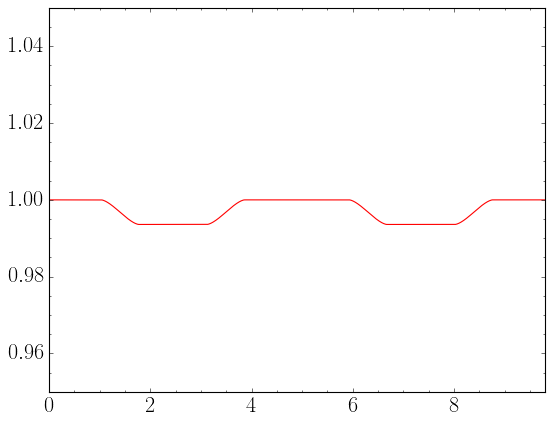

In [33]:
k, a, i, t0, P = .08, 1.2, math.pi/4, 0, best_period.value
print(a*np.cos(i))
print(k, a, i, t0, P)
tarr = np.linspace(0, P, 1e3)

flux = [transitFlux(t, k, a, i, t0, P, F0=1) for t in tarr]

plt.plot(tarr, flux, color='r')
# plt.plot(tarr, skySep(tarr, a, i, t0, P))
# plt.axhline(1+k, color='k')
# plt.axhline(1-k, color='k')
plt.ylim(0.95,1.05)
plt.xlim(0,P)
plt.ticklabel_format(useOffset=False)
plt.minorticks_on()
plt.show()

# plt.plot(tarr, skySep(tarr, a, i, t0, P));

**Problem 3:** Use your model to fit the data ‘mystery_planet02.txt’. What is the
period? What is the depth, impact parameter, and duration of this
transiting body? What is the density of the star?

In [8]:
data = pd.read_csv('files/mystery_planet02.txt', delim_whitespace=True, header=None)

time, flux, flux_err = np.array(data[0]), np.array(data[1]), np.array(data[2])

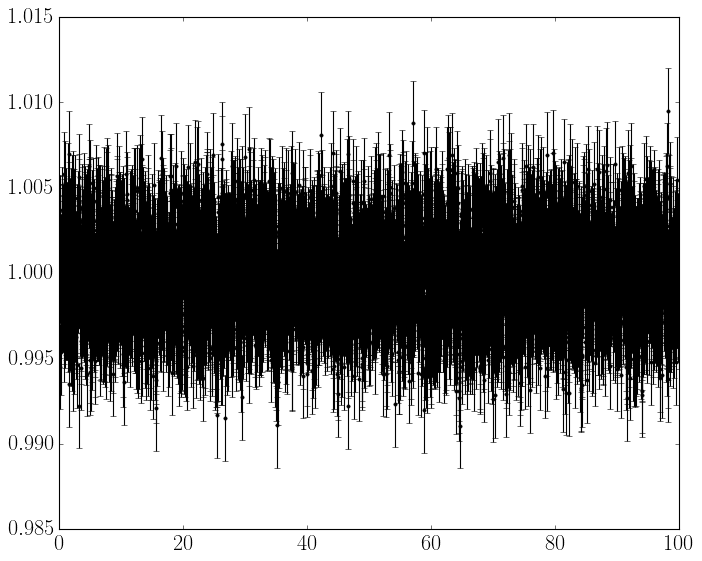

In [9]:
plt.figure(figsize=[10,8])
plt.errorbar(time, flux, yerr=flux_err, fmt='.', color='k')
plt.ticklabel_format(useOffset=False)
plt.show()

In [14]:
def phase_fold(time, rv_val, rv_err, P):
    
    fold = time % P
    phase_sort = np.argsort(fold)

    phase_time = fold[phase_sort]
    phase_rv_val = rv_val[phase_sort]
    phase_rv_err = rv_err[phase_sort]
    
    return phase_time, phase_rv_val, phase_rv_err

In [10]:
from astropy.timeseries import BoxLeastSquares
import astropy.units as u

In [15]:
model = BoxLeastSquares(time * u.day, flux, dy=flux_err)

periods = np.linspace(1, 50, 1e5) * u.day
periodogram = model.power(periods, 0.2)

best period: 9.793627936279362 d


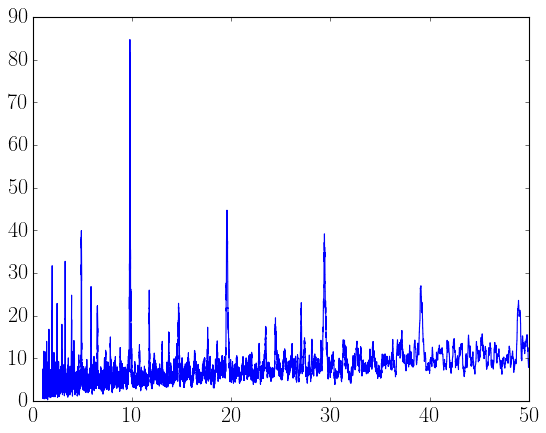

In [16]:
plt.plot(periodogram.period, periodogram.power);
print('best period:', periodogram.period[np.argmax(periodogram.power)])

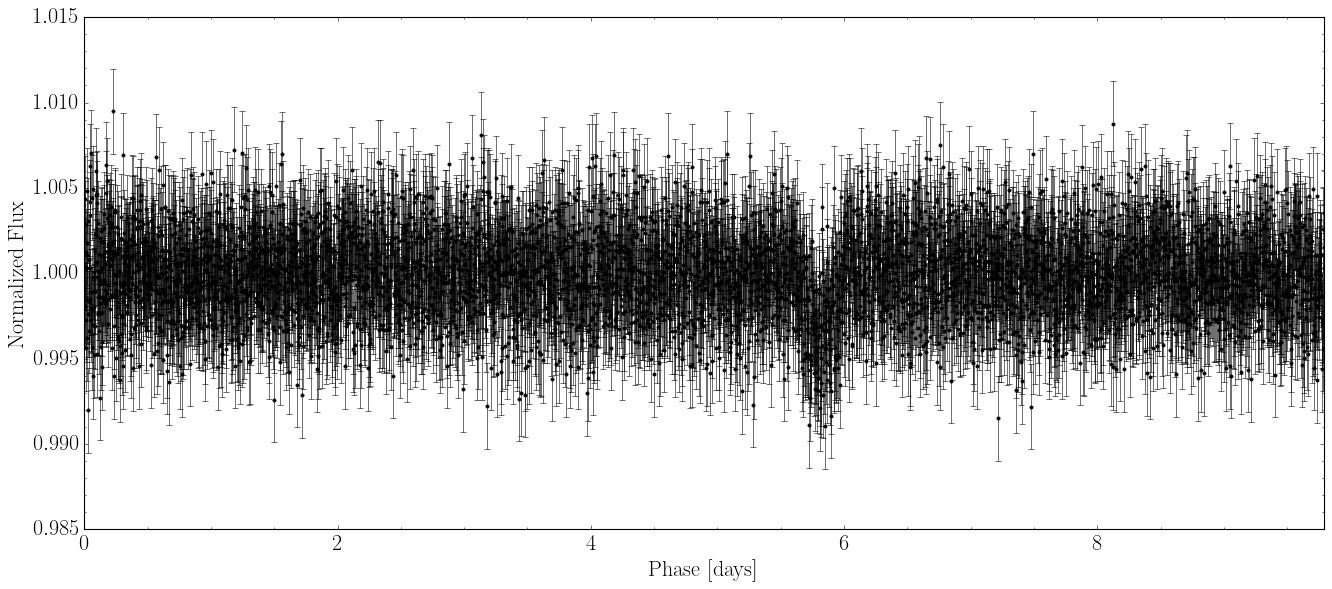

In [17]:
best_period = periodogram.period[np.argmax(periodogram.power)]/u.day
phase_time, phase_flux, phase_flux_err = phase_fold(time, flux, flux_err, best_period)

plt.figure(figsize=[20,8])
plt.errorbar(phase_time, phase_flux, yerr=phase_flux_err, fmt='.', color='k', elinewidth=.5)
# plt.scatter(phase_time, phase_flux, color='k')
plt.ticklabel_format(useOffset=False)
plt.xlim(0, best_period)
plt.xlabel('Phase [days]', fontsize=20)
plt.ylabel(r'Normalized Flux', fontsize=20)
plt.minorticks_on()
plt.show()

**Extra Credit:** find the probability distribution of parameters
assuming a circular orbit

In [205]:
min(flux)

0.9707437213370124

In [206]:
flux_err

array([0.0025, 0.0025, 0.0025, ..., 0.0025, 0.0025, 0.0025])